In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

In [29]:
N = 16
two_N = 32
nearest_square = 36
sqrt_N = 6

n = torch.arange(nearest_square)
omegas = torch.exp(2j * torch.pi * n / nearest_square)

In [176]:
def ref_dft_matrix(N):
    """Compute the DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    # M = torch.exp(-2j * torch.pi * n * k / N)
    # return torch.view_as_real(M)
    M = torch.flip(torch.cos(torch.pi * n * (k + 0.5) / N), dims=(1,))
    return M

def ref_sin_matrix(N):
    """Compute the DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    # M = torch.exp(-2j * torch.pi * n * k / N)
    # return torch.view_as_real(M)
    M = torch.flip(torch.sin(torch.pi * n * (k + 0.5) / N), dims=(1,))
    return M

def ref_idft_matrix(N):
    """Compute the inverse DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    # n = torch.arange(N)
    # # n = torch.arange(N).cuda()
    # k = n.view(-1, 1)
    # M = torch.exp(2j * torch.pi * n * k / N) / N
    # return torch.view_as_real(M)

    M = ref_dft_matrix(N)
    return torch.linalg.inv(M)

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N]

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

def get_P_matrix(N, sqrt_N):
    idx = torch.arange(N)
    idx = rearrange(idx, '(m n) -> (n m)', m = sqrt_N)

    P = torch.diag(torch.ones(N))[idx]

    return P

In [31]:
k = torch.randn(N)

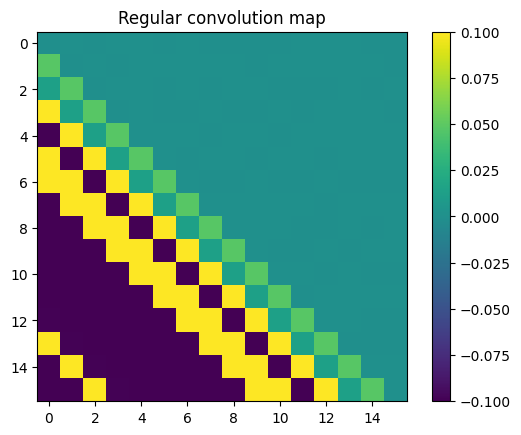

In [32]:
pad_mat = torch.zeros(nearest_square, N)
pad_mat[nearest_square // 2:nearest_square // 2 + N, :] = torch.diag(torch.ones(N))

# unpad_mat = pad_mat.T
unpad_mat = torch.zeros(N, nearest_square)
unpad_mat[:, :N] = torch.diag(torch.ones(N))

fft_2n = ref_dft_matrix(nearest_square)
# ifft_2n = torch.flip(torch.view_as_complex(ref_idft_matrix(nearest_square)), dims=(1,))
ifft_2n = torch.linalg.inv(fft_2n)
# fft_2n = torch.view_as_complex(ref_dft_matrix(nearest_square))
# ifft_2n = torch.view_as_complex(ref_idft_matrix(nearest_square))
K_f = fft_2n @ pad_mat @ k

K_f_diag = torch.diag(K_f)

conv_map = unpad_mat @ ifft_2n @ K_f_diag @ fft_2n @ pad_mat

plt.title('Regular convolution map')
plt.imshow(conv_map, vmin=-.1, vmax=.1)
plt.colorbar()

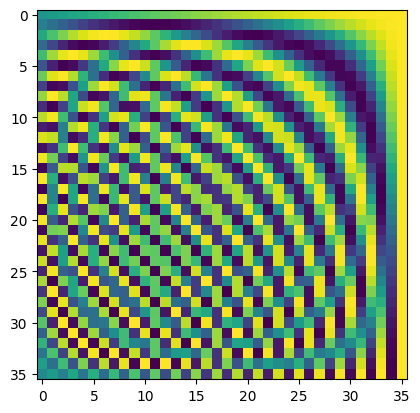

In [33]:
plt.imshow(fft_2n)

In [34]:
pad_mat.shape

torch.Size([36, 16])

## Flipped R

Now we flip L and R to be flipped upper triangular.

## Fixed

In [35]:
N = 8
nearest_square=16
sqrt_N = 4

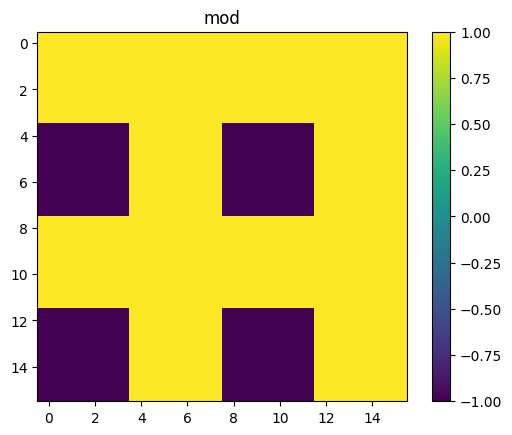

In [36]:
mod = torch.ones(nearest_square, nearest_square)
for i in range(sqrt_N):
    for j in range(sqrt_N):
        if (i * j) % 2 != 0:
            mod[i * sqrt_N : (i + 1) * sqrt_N, j * sqrt_N : (j + 1) * sqrt_N] = -1
mod = torch.flip(mod, dims=(1,))
plt.title('mod')
plt.imshow(mod)
plt.colorbar()

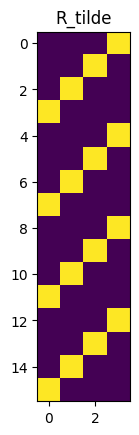

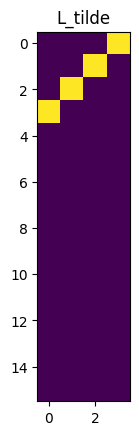

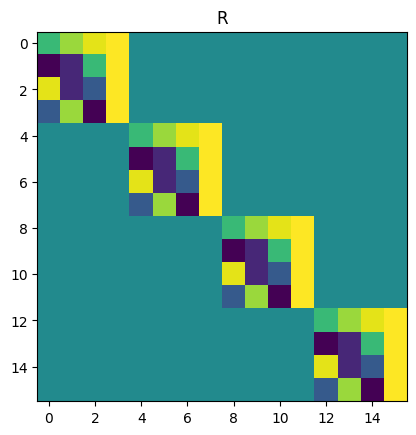

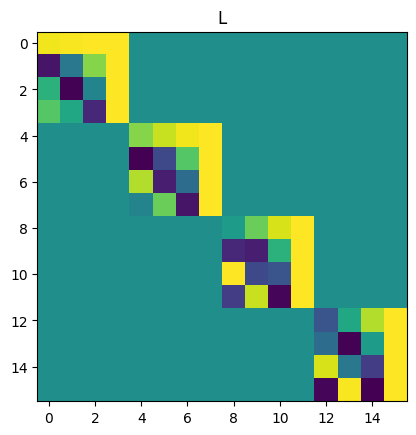

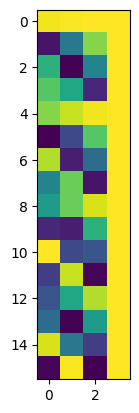

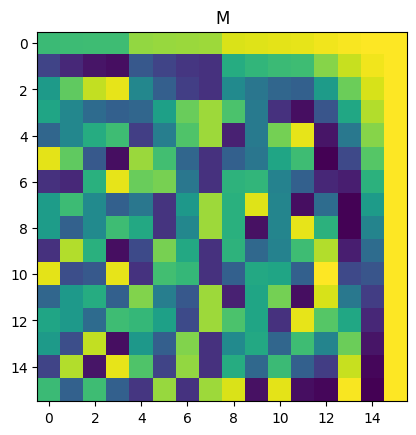

In [37]:
P = get_P_matrix(nearest_square, sqrt_N)

R_tilde = torch.zeros(nearest_square, sqrt_N)

for i in range(sqrt_N):
    R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)), dims=(1,))

    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.ones(sqrt_N))
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.randn(sqrt_N-2), diagonal=-2)
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.randn(sqrt_N-4), diagonal=-4)

    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :], dims=(0,))
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :][sqrt_N // 2:,:sqrt_N // 2] = 0

plt.imshow(R_tilde)
plt.title('R_tilde')
plt.show()

L_tilde = torch.zeros(nearest_square, sqrt_N)

for i in range(1):
    L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)), dims=(1,))

    # L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)) + torch.tril(torch.randn(sqrt_N, sqrt_N)), dims=(0,))

plt.imshow(L_tilde)
plt.title('L_tilde')
plt.show()

block_R = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_R[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] =  torch.flip(ref_dft_matrix(sqrt_N), dims=(1,)) @ R_tilde[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_R)
plt.title('R')
plt.show()

L = P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde
block_L = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_L[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] = L[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_L)
plt.title('L')
plt.show()

plt.imshow(P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde)
plt.show()

M_real_fixed = P @ block_L @ P @ block_R @ P
plt.title('M')
plt.imshow(M_real_fixed)

M_prime_fixed = mod * M_real_fixed

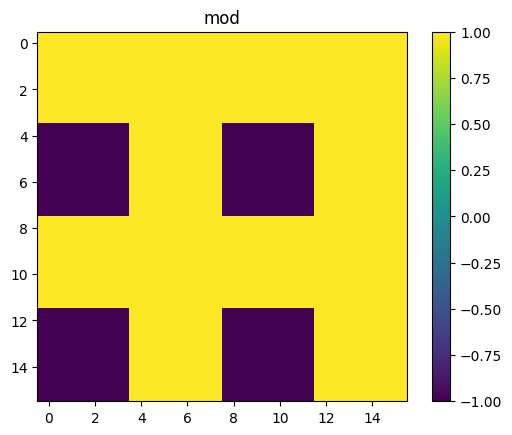

In [38]:
mod = torch.ones(nearest_square, nearest_square)
for i in range(sqrt_N):
    for j in range(sqrt_N):
        if (i * j) % 2 != 0:
            mod[i * sqrt_N : (i + 1) * sqrt_N, j * sqrt_N : (j + 1) * sqrt_N] = -1
mod = torch.flip(mod, dims=(1,))
plt.title('mod')
plt.imshow(mod)
plt.colorbar()

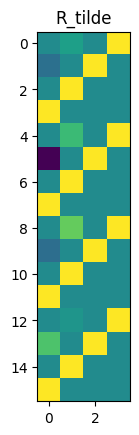

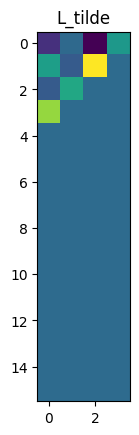

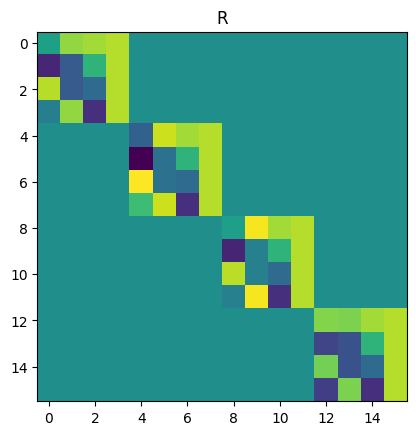

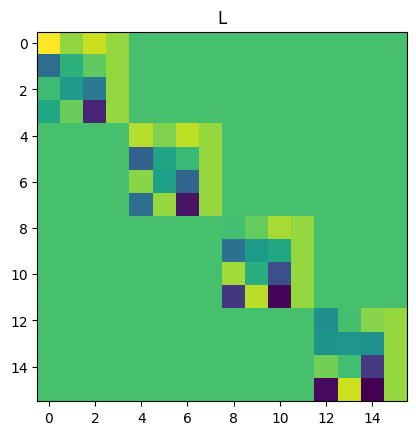

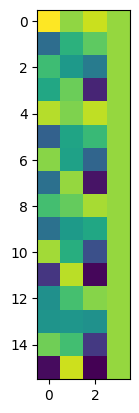

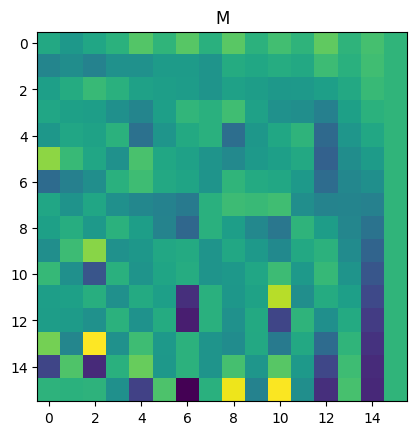

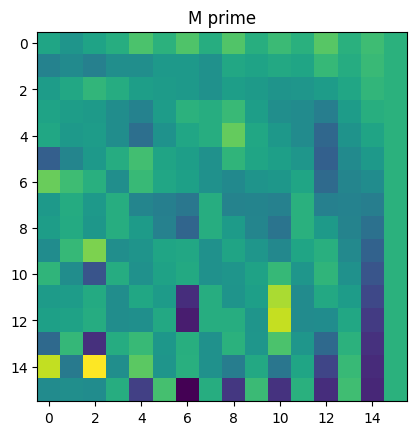

In [39]:
P = get_P_matrix(nearest_square, sqrt_N)

R_tilde = torch.zeros(nearest_square, sqrt_N)

for i in range(sqrt_N):
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)), dims=(1,))

    R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.ones(sqrt_N))
    R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.randn(sqrt_N-2), diagonal=-2) * 0.5
    R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.randn(sqrt_N-4), diagonal=-4) * 0.5

    R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :], dims=(0,))
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :][sqrt_N // 2:,:sqrt_N // 2] = 0

plt.imshow(R_tilde)
plt.title('R_tilde')
plt.show()

L_tilde = torch.zeros(nearest_square, sqrt_N)

for i in range(1):
    # L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)), dims=(1,))

    L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)) + torch.tril(torch.randn(sqrt_N, sqrt_N)) * 0.5, dims=(0,))

plt.imshow(L_tilde)
plt.title('L_tilde')
plt.show()

block_R = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_R[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] =  torch.flip(ref_dft_matrix(sqrt_N), dims=(1,)) @ R_tilde[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_R)
plt.title('R')
plt.show()

L = P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde
block_L = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_L[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] = L[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_L)
plt.title('L')
plt.show()

plt.imshow(P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde)
plt.show()

M_real_learned = P @ block_L @ P @ block_R @ P
plt.title('M')
plt.imshow(M_real_learned)
plt.show()

M_prime_learned = mod * M_real_learned

plt.title('M prime')
plt.imshow(M_prime_learned)
plt.show()

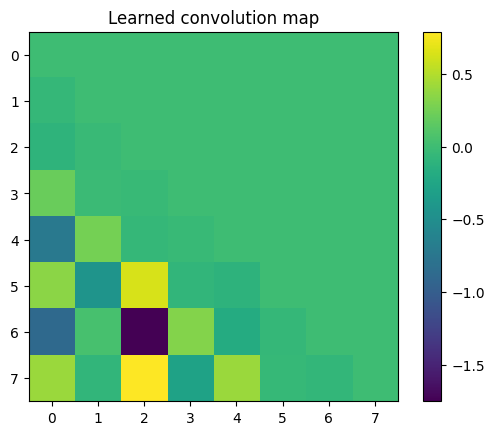

In [40]:
k = torch.randn(N)
pad_mat = torch.zeros(nearest_square, N)
pad_mat[nearest_square // 2:nearest_square // 2 + N, :] = torch.diag(torch.ones(N))

# unpad_mat = pad_mat.T
unpad_mat = torch.zeros(N, nearest_square)
unpad_mat[:, :N] = torch.diag(torch.ones(N))

fft_2n = M_prime_learned
# ifft_2n = torch.flip(torch.view_as_complex(ref_idft_matrix(nearest_square)), dims=(1,))
ifft_2n = torch.linalg.inv(M_prime_fixed)
# fft_2n = torch.view_as_complex(ref_dft_matrix(nearest_square))
# ifft_2n = torch.view_as_complex(ref_idft_matrix(nearest_square))
K_f = fft_2n @ pad_mat @ k

K_f_diag = torch.diag(K_f)

conv_map = unpad_mat @ ifft_2n @ K_f_diag @ fft_2n @ pad_mat

plt.title('Learned convolution map')
plt.imshow(conv_map)
plt.colorbar()

## Roll the `mod` into the computation

In [15]:
B = 10
H = 12
u = torch.randn(B, H, N)

In [16]:
u[0][0]

tensor([-0.0535,  1.1889,  0.0896, -1.6200, -0.1797, -0.4061, -1.3047,  1.7359])

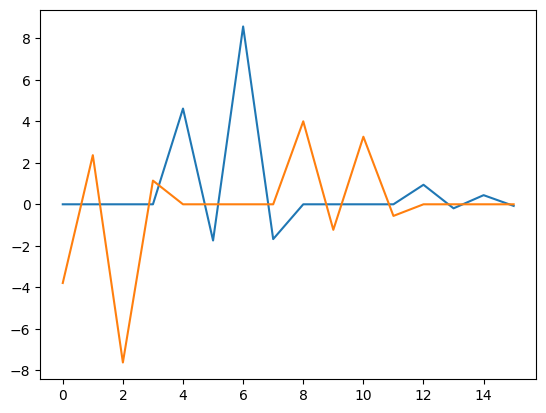

In [76]:
u_mod = torch.zeros(nearest_square).float()
for i in range(sqrt_N):
    u_mod[i * sqrt_N:(i + 1) * sqrt_N] = 1. if i % 2 == 0 else -1.

u_padded = nn.ConstantPad1d((0, nearest_square // 2 - u.shape[-1]), 0)(u)
u_padded = nn.ConstantPad1d((nearest_square // 2, 0), 0)(u_padded)

u1 = torch.einsum('nm, ...n -> ...m', M_real_learned, u_padded)
u2 = torch.einsum('nm, ...n -> ...m', M_real_learned, u_mod * u_padded)

u_true = torch.einsum('nm, ...n -> ...m', M_prime_learned, u_mod * u_padded)

u_final = torch.zeros(B, H, nearest_square).float()
for i in range(sqrt_N):
    u_final[..., i * sqrt_N:(i + 1) * sqrt_N] = u1[..., i * sqrt_N:(i + 1) * sqrt_N] if i % 2 == 0 else u2[..., i * sqrt_N:(i + 1) * sqrt_N]

plt.plot((u_true - u1)[2, 2])
plt.plot((u_true - u2)[2, 2])
# plt.plot((u_final - u_true)[2, 2])

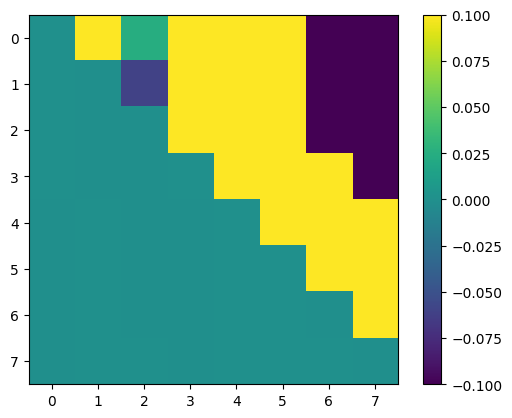

In [19]:
u_new = torch.randn(u.shape)
u_cloned = u.clone()

y = torch.einsum("nm,...m->...n", conv_map, u)

new_ys = []
for i in range(1, max(8, N + 1)):
    u_cloned[..., -i] = u_new[..., -i]
    new_ys.append(torch.einsum("nm,...m->...n", conv_map, u_cloned))

new_ys = torch.flip(torch.stack(new_ys), (0,))

diff = y - new_ys

plt.imshow(diff[:, B // 2, H // 2, :].detach().numpy(), vmin=-0.1, vmax=0.1)
plt.colorbar()

# Compute Inverse with Monarch

Problem: $C_N^{-1}$ above is not Monarch. Can we write down a $C_N^{-1}$ that maintains causality, and can be computed with Monarch?

Atri claims the following $C_N$ satisfies these conditions:
$$
C_N[i,j] = \cos(\pi(i+1/2)j/N),
$$
via decomposition into
$$
C_N[i,j] = \overline{C_N}[i,j] + \overline{S_N}[i,j],
$$
where $\overline{C_N}[i,j]$ and $\overline{S_N}[i,j]$ can be computed with Monarch.

Below, we test:
1. Does this $C_N$ give a causal relationship
2. Can we decompose it into $\overline{C_N}[i,j]$ and $\overline{S_N}[i,j]$
3. Can we compute $\overline{C_N}[i,j]$ and $\overline{S_N}[i,j]$ with Monarch

## Test Causality of $C_N$

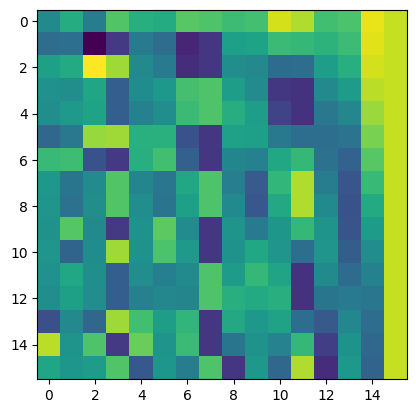

In [20]:
# make sure the M' is still saved from cells before
plt.imshow(M_prime_learned)

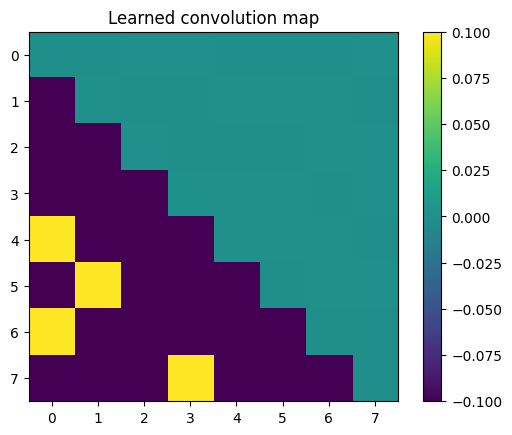

In [21]:
# This should give a causal map

def show_conv(inv_mat):
    k = torch.randn(N)
    pad_mat = torch.zeros(nearest_square, N)
    pad_mat[nearest_square // 2:nearest_square // 2 + N, :] = torch.diag(torch.ones(N))

    unpad_mat = torch.zeros(N, nearest_square)
    unpad_mat[:, :N] = torch.diag(torch.ones(N))

    fft_2n = M_prime_learned
    K_f = fft_2n @ pad_mat @ k

    K_f_diag = torch.diag(K_f)

    conv_map = unpad_mat @ inv_mat @ K_f_diag @ fft_2n @ pad_mat

    plt.title('Learned convolution map')
    plt.imshow(conv_map, vmin=-0.1, vmax=0.1)
    plt.colorbar()

show_conv(torch.linalg.inv(M_prime_fixed))

In [22]:
def shifted_cheb_matrix(N, shift_n=0.0, shift_k=0.5):
    n = torch.arange(N)
    k = n.view(-1, 1)
    M = torch.flip(torch.cos(torch.pi * (n+shift_n) * (k + shift_k) / N), dims=(1,))
    return M

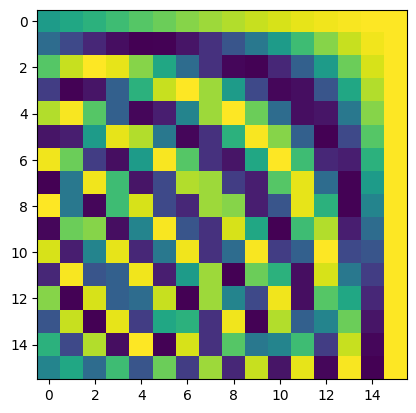

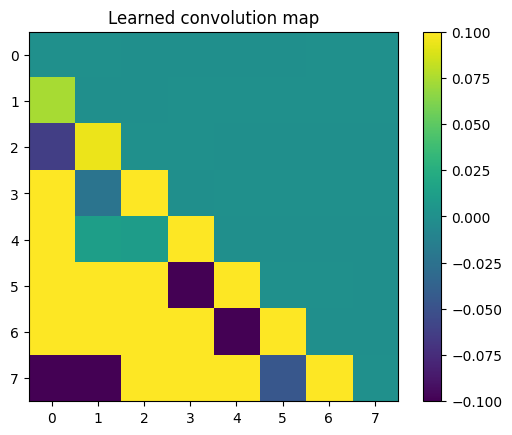

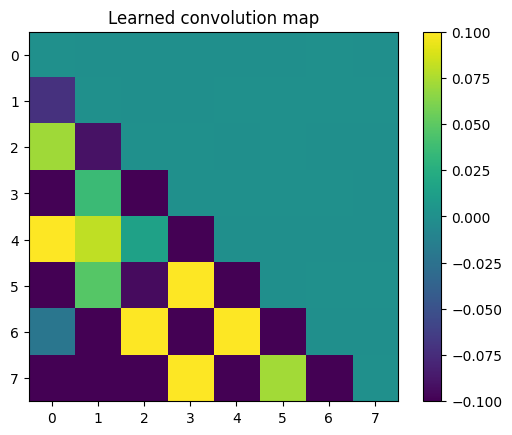

In [23]:
plt.imshow(shifted_cheb_matrix(nearest_square))
plt.show()
show_conv(torch.linalg.inv(shifted_cheb_matrix(nearest_square, 0.0, 0.5)))
plt.show()
show_conv(torch.linalg.inv(shifted_cheb_matrix(nearest_square, 0.0, 0.5)))

## Test easy transpose

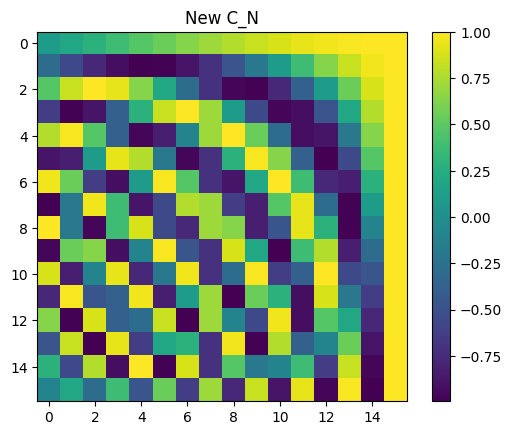

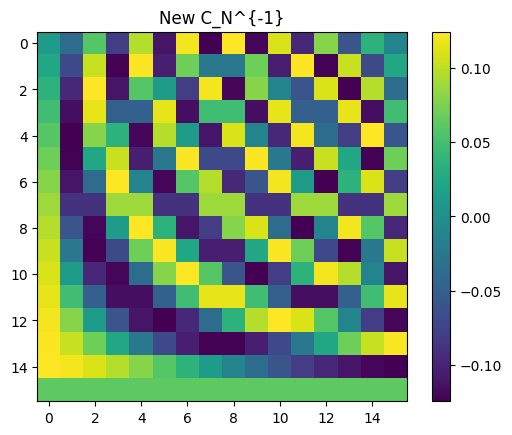

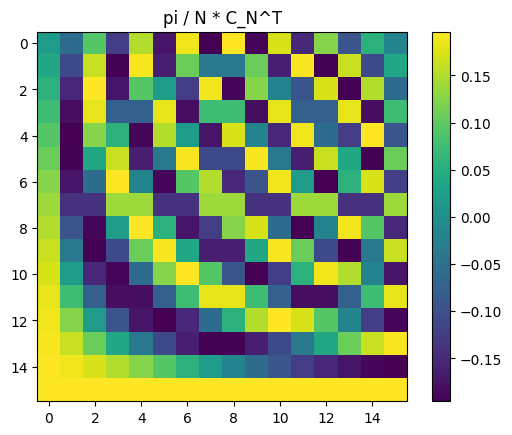

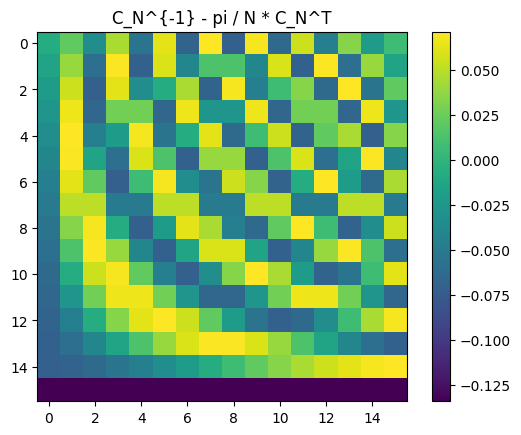

In [24]:
plt.title('New C_N')
plt.imshow(shifted_cheb_matrix(nearest_square, 0.0, 0.5))
plt.colorbar()
plt.show()
plt.title('New C_N^{-1}')
plt.imshow(torch.linalg.inv(shifted_cheb_matrix(nearest_square, 0.0, 0.5)))
plt.colorbar()
plt.show()
plt.title('pi / N * C_N^T')
plt.imshow(torch.pi / nearest_square * shifted_cheb_matrix(nearest_square, 0.0, 0.5).T)
plt.colorbar()
plt.show()
plt.title('C_N^{-1} - pi / N * C_N^T')
plt.imshow(torch.linalg.inv(shifted_cheb_matrix(nearest_square, 0.0, 0.5)) - torch.pi / nearest_square * shifted_cheb_matrix(nearest_square, 0.0, 0.5).T)
plt.colorbar()
plt.show()

## ...But it doesn't matter! Lol

Here, I use C_N.T instead of C_N^{-1}.

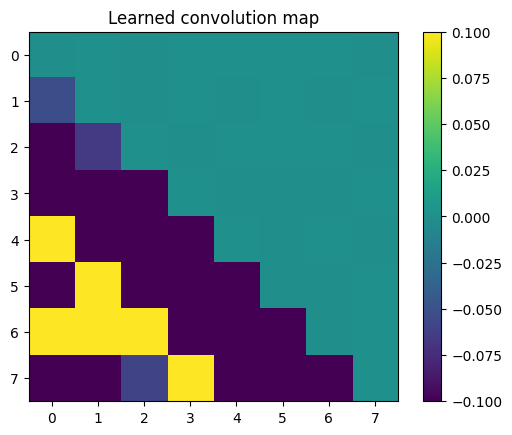

In [25]:
show_conv(shifted_cheb_matrix(nearest_square, 0.0, 0.5).T)

## Next: Can we get $C_N.T$ from Monarch?

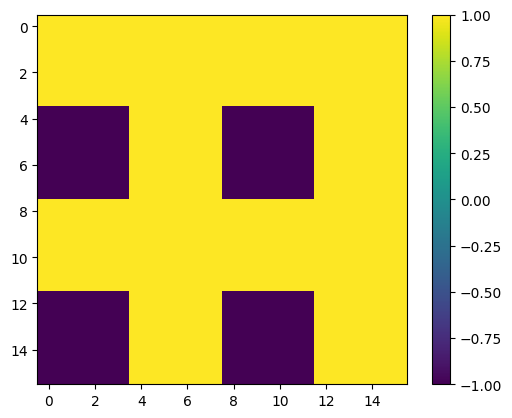

In [162]:
mod2 = torch.ones(nearest_square, nearest_square)
for i in range(sqrt_N):
    for j in range(sqrt_N):
        if (i * j) % 2 != 0:
            mod2[i * sqrt_N : (i + 1) * sqrt_N, j * sqrt_N : (j + 1) * sqrt_N] = -1
mod2 = torch.flip(mod2, dims=(1,))
# plt.title('mod')
plt.imshow(mod2)
plt.colorbar()

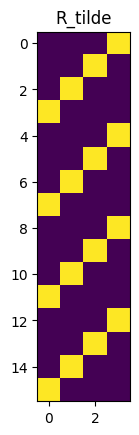

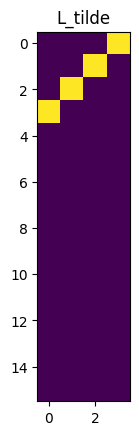

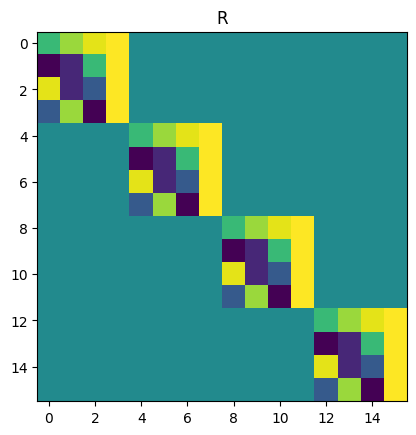

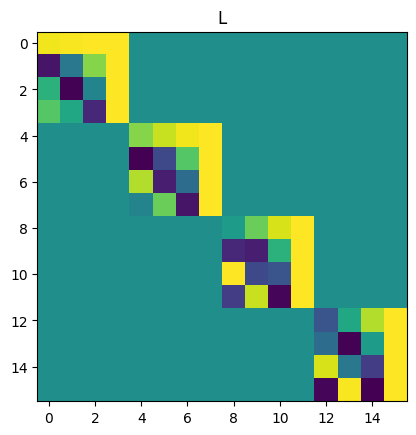

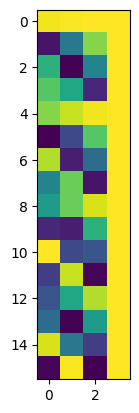

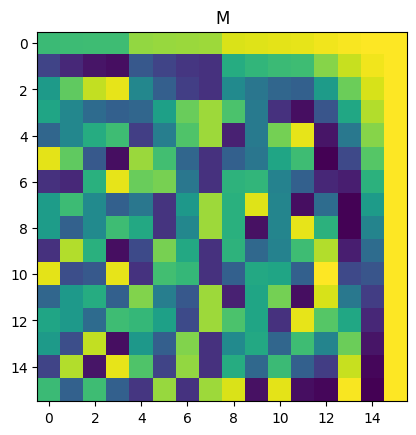

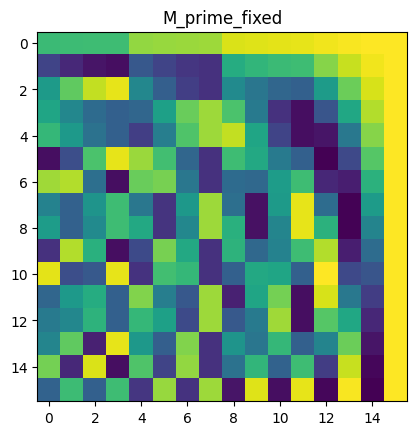

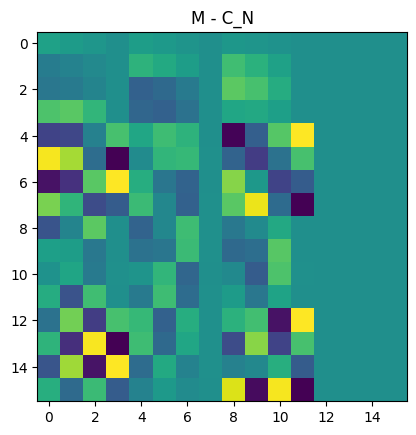

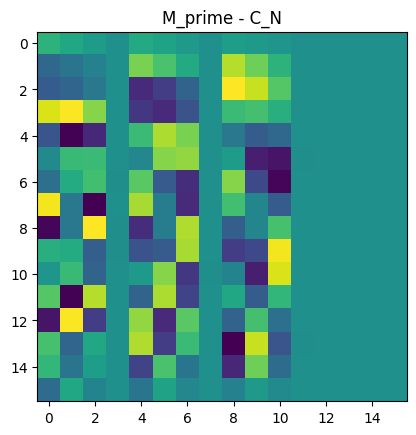

In [175]:
P = get_P_matrix(nearest_square, sqrt_N)

R_tilde = torch.zeros(nearest_square, sqrt_N)

for i in range(sqrt_N):
    R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)), dims=(1,))

    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.ones(sqrt_N))
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.randn(sqrt_N-2), diagonal=-2)
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] += torch.diag(torch.randn(sqrt_N-4), diagonal=-4)

    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :], dims=(0,))
    # R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :][sqrt_N // 2:,:sqrt_N // 2] = 0

plt.imshow(R_tilde)
plt.title('R_tilde')
plt.show()

L_tilde = torch.zeros(nearest_square, sqrt_N)

for i in range(1):
    L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)), dims=(1,))

    # L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.flip(torch.diag(torch.ones(sqrt_N)) + torch.tril(torch.randn(sqrt_N, sqrt_N)), dims=(0,))

plt.imshow(L_tilde)
plt.title('L_tilde')
plt.show()

block_R = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_R[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] =  torch.flip(ref_dft_matrix(sqrt_N), dims=(1,)) @ R_tilde[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_R)
plt.title('R')
plt.show()

L = P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde
# L = P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde
block_L = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_L[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] = L[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_L)
plt.title('L')
plt.show()

plt.imshow(P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde)
plt.show()

M_real = P @ block_L @ P @ block_R @ P
plt.title('M')
plt.imshow(M_real)
plt.show()

M_prime_fixed = mod2 * M_real

# plt.imshow(M_prime_fixed - )
plt.title('M_prime_fixed')
plt.imshow(M_prime_fixed)

plt.show()
plt.title('M - C_N')
plt.imshow(M_real - (ref_dft_matrix(nearest_square)))

plt.show()
plt.title("M_prime - C_N")
plt.imshow(M_prime_fixed - (ref_dft_matrix(nearest_square)))

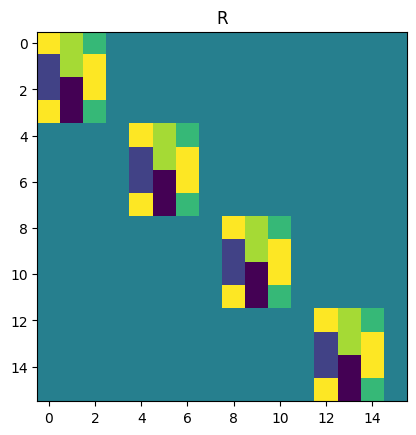

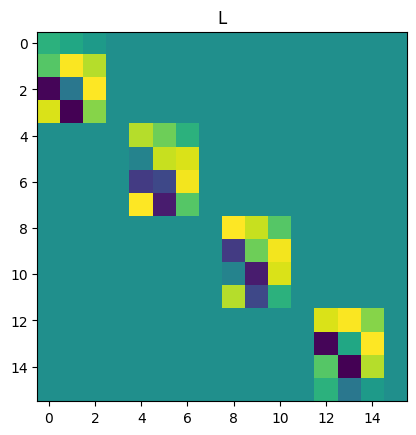

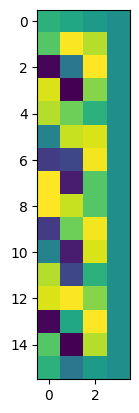

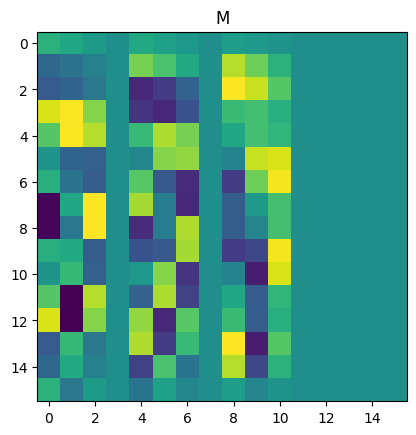

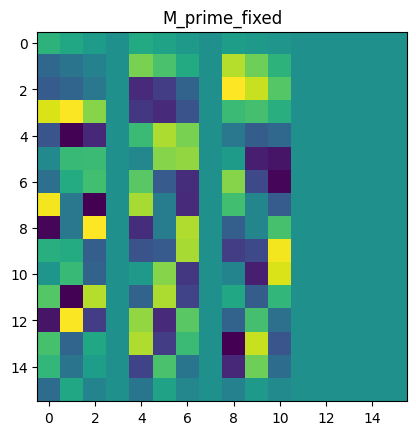

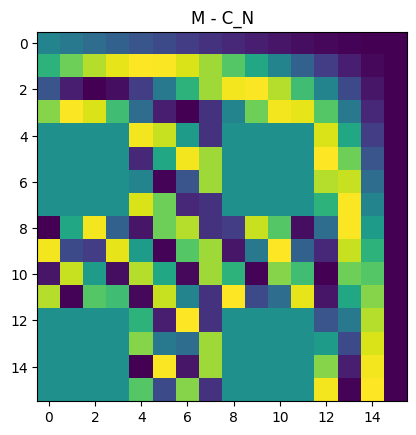

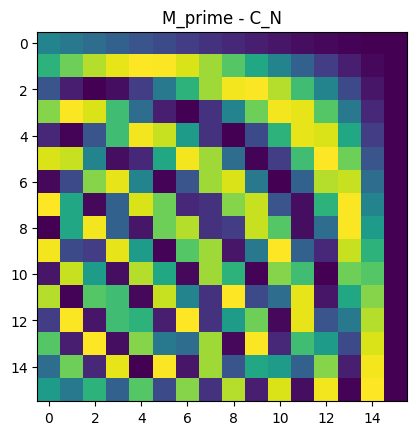

In [181]:
P = get_P_matrix(nearest_square, sqrt_N)

block_R_sin = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_R_sin[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] =  torch.flip(ref_sin_matrix(sqrt_N), dims=(1,)) @ R_tilde[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_R_sin)
plt.title('R')
plt.show()

L_sin = P @ (torch.flip(ref_sin_matrix(nearest_square), dims=(1,))) @ L_tilde
# L = P @ (torch.flip(ref_dft_matrix(nearest_square), dims=(1,))) @ L_tilde
block_L_sin = torch.zeros(nearest_square, nearest_square)
for i in range(sqrt_N):
    block_L_sin[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N] = L_sin[i * sqrt_N : (i + 1) * sqrt_N, :]

plt.imshow(block_L_sin)
plt.title('L')
plt.show()

plt.imshow(P @ (torch.flip(ref_sin_matrix(nearest_square), dims=(1,))) @ L_tilde)
plt.show()

M_real_sin = P @ block_L_sin @ P @ block_R_sin @ P
plt.title('M')
plt.imshow(M_real_sin)
plt.show()

M_prime_fixed_sin = mod2 * M_real_sin

# plt.imshow(M_prime_fixed - )
plt.title('M_prime_fixed')
plt.imshow(M_prime_fixed_sin)

plt.show()
plt.title('M - C_N')
plt.imshow(M_real_sin - (ref_dft_matrix(nearest_square)))

plt.show()
plt.title("M_prime - C_N")
plt.imshow(M_prime_fixed_sin - (ref_dft_matrix(nearest_square)))

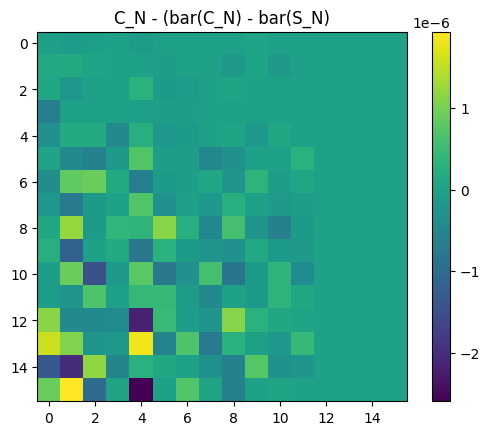

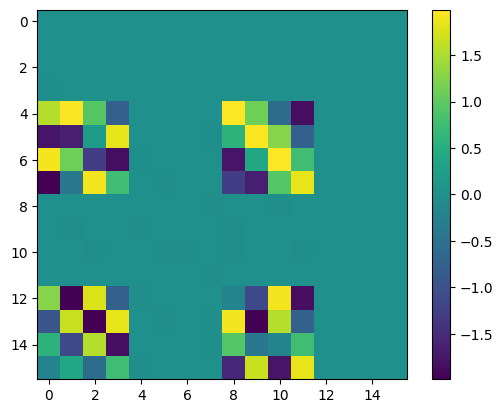

In [230]:
plt.title('C_N - (bar(C_N) - bar(S_N)')
plt.imshow(ref_dft_matrix(nearest_square) - mod3 * (M_real - M_real_sin))
plt.colorbar()
plt.show()
plt.imshow(ref_dft_matrix(nearest_square) - (M_real - M_real_sin))
plt.colorbar()

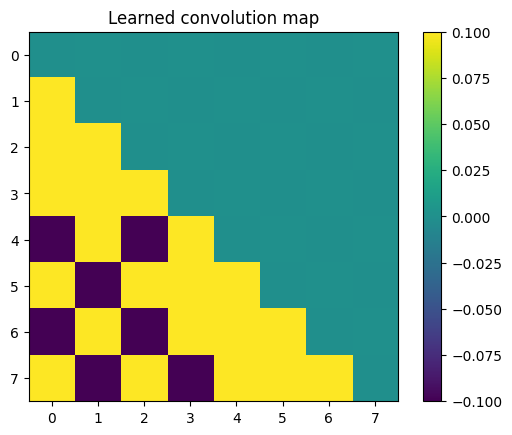

In [232]:
show_conv((mod3 * (M_real - M_real_sin)).T)

## Compute $M^T u$ with Monarch

First, make sure we can compute $M^T u$ with Monarch, using $u^T M$. Then, we use the masking trick to get $M^T u'$.

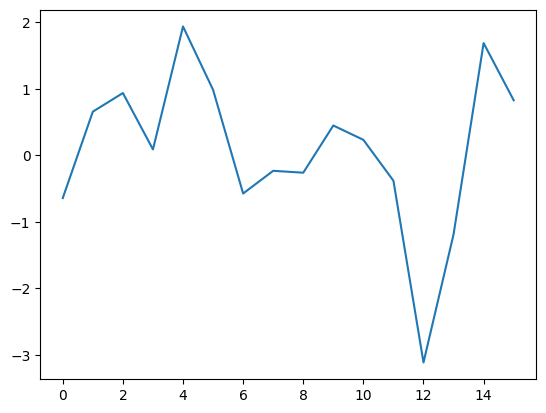

In [240]:
u_out = torch.randn(B, H, nearest_square)

plt.plot(u_out[0][0])

In [241]:
block_R.shape

torch.Size([16, 16])

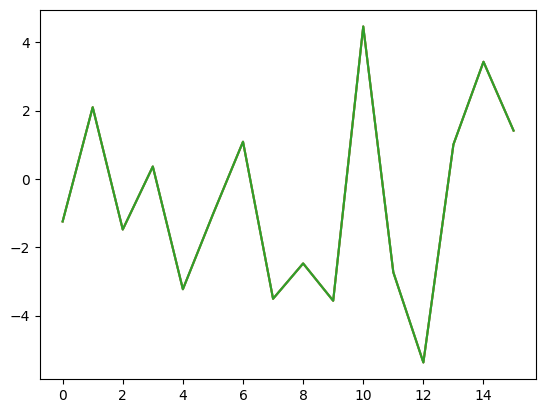

In [245]:
u_T_M_Monarch = torch.einsum('nm,...m->...n', P, u_out)
u_T_M_Monarch = torch.einsum('nm,...n->...m', block_L, u_T_M_Monarch)
u_T_M_Monarch = torch.einsum('nm,...m->...n', P, u_T_M_Monarch)
u_T_M_Monarch = torch.einsum('nm,...n->...m', block_R, u_T_M_Monarch)
u_T_M_Monarch = torch.einsum('nm,...m->...n', P, u_T_M_Monarch)

u_T_M_ref = torch.einsum('nm,...n->...m', M_real, u_out)

M_T_u_ref = torch.einsum('nm,...m->...n', M_real.T, u_out)

plt.plot(u_T_M_Monarch[0][0])
plt.plot(u_T_M_ref[0][0])
plt.plot(M_T_u_ref[0][0])

In [246]:
block_L_diag = torch.zeros(sqrt_N, sqrt_N, sqrt_N)
block_R_diag = torch.zeros(sqrt_N, sqrt_N, sqrt_N)
for i in range(sqrt_N):
    block_L_diag[i] = block_L[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N]
    block_R_diag[i] = block_R[i * sqrt_N : (i + 1) * sqrt_N, i * sqrt_N : (i + 1) * sqrt_N]

In [252]:
def apply_permutation(x, sqrt_N):
    return rearrange(x, '... (m n) -> ... (n m)', n=sqrt_N)

u_T_M_Monarch_2 = apply_permutation(u_out, sqrt_N)
u_T_M_Monarch_2 = torch.einsum(
    'bnm,...bn->...bm', block_L_diag, u_T_M_Monarch_2.view(B, H, sqrt_N, sqrt_N)).reshape(B, H, -1)
u_T_M_Monarch_2 = apply_permutation(u_T_M_Monarch_2, sqrt_N)
u_T_M_Monarch_2 = torch.einsum(
    'bnm,...bn->...bm', block_R_diag, u_T_M_Monarch_2.view(B, H, sqrt_N, sqrt_N)).reshape(B, H, -1)
u_T_M_Monarch_2 = apply_permutation(u_T_M_Monarch_2, sqrt_N)

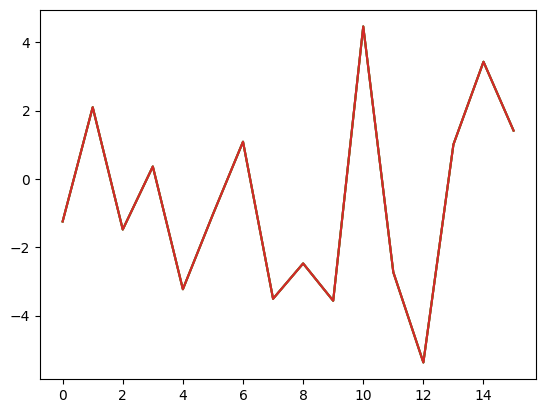

In [253]:
plt.plot(u_T_M_Monarch[0][0])
plt.plot(u_T_M_ref[0][0])
plt.plot(M_T_u_ref[0][0])
plt.plot(u_T_M_Monarch_2[0][0])

## Correction Factor

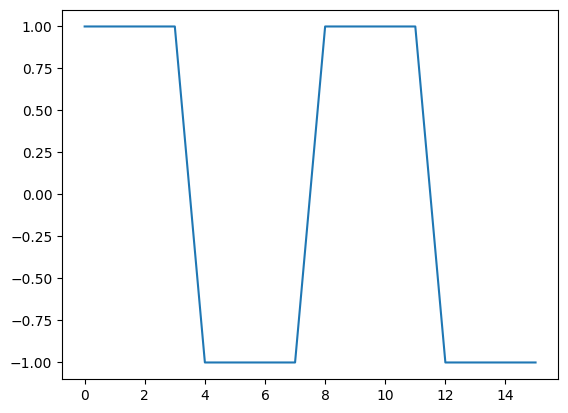

In [141]:
u_mod = torch.zeros(nearest_square).float()
u_mod_mask = torch.zeros(nearest_square).float()
u_mod_mask_inv = torch.zeros(nearest_square).float()
for i in range(sqrt_N):
    u_mod[i * sqrt_N:(i + 1) * sqrt_N] = 1. if i % 2 == 0 else -1.
    u_mod_mask[i * sqrt_N:(i + 1) * sqrt_N] = 1. if i % 2 == 0 else 0.
    u_mod_mask_inv[i * sqrt_N:(i + 1) * sqrt_N] = 0. if i % 2 == 0 else 1.
plt.plot(u_mod)

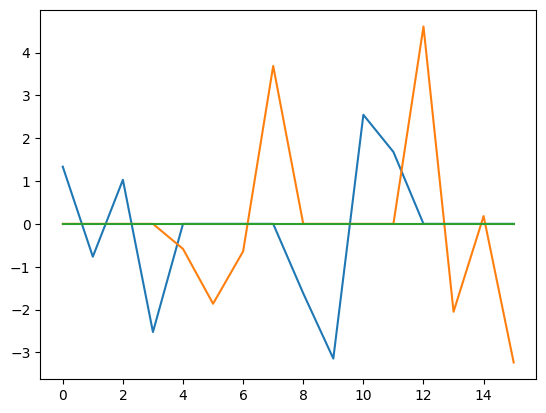

In [138]:
u_T_M_prime = torch.einsum('nm, ...n -> ...m', M_prime_fixed, u_out)
# plt.plot(u_T_M_prime[0][0])

u_T_M_real = torch.einsum('nm, ...n -> ...m', M_real_fixed, u_out)
u_T_mod_M_real = torch.einsum('nm, ...n -> ...m', M_real_fixed, u_out * u_mod)

plt.plot(u_T_M_real[0][0] - u_T_M_prime[0][0])
plt.plot(u_T_mod_M_real[0][0] - u_T_M_prime[0][0])

u_T_M_real_final = u_T_M_real * u_mod_mask_inv + u_T_mod_M_real * u_mod_mask

plt.plot(u_T_M_real_final[0][0] - u_T_M_prime[0][0])

# u_front_T_M_real = torch.einsum('nm, ...n -> ...m', M_real_fixed, u_padded_front)
# plt.plot(u_front_T_M_real[0][0] - u_T_M_prime[0][0])

# u_rear_T_M_real = torch.einsum('nm, ...n -> ...m', M_real_fixed, u_padded_rear)
# plt.plot(u_rear_T_M_real[0][0])